In [7]:
import matplotlib.pyplot as plt

p = 17

In [8]:
# Exponentiation rapide
def pow(x: float, n: int):
    if n==0 :
        return 1
    if n%2 == 0:
        return pow(x, n/2)**2
    else:
        return x * pow(x, (n-1)/2)**2

class IntModP(int):
    def __new__(cls, n):
        return int.__new__(cls, n % p)
        
    # Affichage en console
    def __str__(self): 
        return int.__str__(self) + f" [{p}]"
    
    # Opposé mod p
    def __neg__(self):
        return IntModP(int.__neg__(self))

    # Addition modulo p
    def __add__(self, q):
        return IntModP(int.__add__(self, q))
    
    # Soustraction mod p
    def __sub__(self, q):
        return IntModP(int.__sub__(self, q))
    
    # Multiplication mod p
    def __mul__(self, q):
        return IntModP(int.__mul__(self, q))
    
    # Puissance mod p
    def __pow__(self, q):
        if q >= 0:
            return IntModP(int.__pow__(self, q))
        else:
            return IntModP(int.__pow__(self.inverse(), -q))

    # Division mod p
    def __truediv__(self, q):
        return IntModP(self * q.inverse())
    
    
    def inverse(self): # O(log(p))
        return IntModP(pow(self, p-2)) # Théorème de Fermat : n**(p-1) * n = 1 [p]

    def inverse_old(self):
        for i in range(p):
            if (self * i) % p == 1:
                return IntModP(i)
        raise Exception(f"{self} n'est pas inversible")

x = IntModP(6)
y = IntModP(3)
x+=y
print(x**2)
y*=x
print(y)



13 [17]
10 [17]


In [9]:
class CurvePoint:
    def __init__(self, a, b, x=None, y=None):
        self.a = IntModP(a)
        self.b = IntModP(b)

        if x==None and y==None :
            self.x = x
            self.y = y
        else:
            self.x = IntModP(x) 
            self.y = IntModP(y)

    # Affichage lors d'un print
    def __str__(self):
        if self.isNeutral():
            return f"Neutre de E(Z/{p}Z)"
        return f"Point de E(Z/{p}Z) : ({self.x}, {self.y})"

    # Egalité de 2 points
    def __eq__(self, q):
        return self.x == q.x and self.y == q.y

    def isNeutral(self):
        return self.x == None and self.y == None

    def __add__(self, q):
        # Si un des 2 est le neutre
        if self.isNeutral():
            return q
        if q.isNeutral():
            return self

        # Si Q=-P
        if q.x == self.x and q.y == -self.y:
            return CurvePoint(self.a, self.b)  # Element neutre

        # Calcul de L (pente)
        L = IntModP(0)
        x1, y1 = self.x, self.y
        x2, y2 = q.x, q.y
        if self == q:
            L = (x1**2 * 3 + self.a) / (y1 * 2)  # Tangente à la courbe en P
        else:
            L = (y1 - y2) / (x1 - x2)  # Coeff directeur de la droite (PQ)

        # Coordonnées du nouveau point :
        x3 = (L**2 - x1 - x2)
        y3 = (-L * x3 - (y1 - L*x1)) 
        return CurvePoint(self.a, self.b,x3, y3)  # Element neutre

    # Produit P*n avec l'algorithme 'Double and add'
    def __mul__(self, n):
        if type(n) != int or n<=0 :
            raise Exception("n doit être un entier positif !")

        bits = bin(n) # Représentation en binaire de n
        result = CurvePoint(self.a, self.b) # Neutre
        current = self # Vaut toujours 2^i * P

        for i in range(len(bits)-1, 1, -1): # On commence par le bit de poids faible
            bit = int(bits[i])
            if bit == 1 :
                result += current
            current = current + current
        return result     

    # Produit n*P :  
    def __rmul__(self, n):
        return self * n
    
P = CurvePoint(3, 8, 2, 3)
Q = CurvePoint(3, 8, 2, 3)
print(P+P+Q+P+P+P+Q)
print(5*P+2*Q)

Point de E(Z/17Z) : (13 [17], 2 [17])
Point de E(Z/17Z) : (13 [17], 2 [17])


In [10]:
class EllipticCurve:
    def __init__(self, a, b):
        self.a = IntModP(a)
        self.b = IntModP(b)
        self.points = []

        if self.discriminant() == 0:
            raise Exception("Le discriminant est nul !")

        self.createPoints()

    def discriminant(self):
        return (-16 * (4 * self.a**3 + 27 * self.b**2))

    def __str__(self) -> str:
        return f"y^2 = x^3 + {self.a}x + {self.b}"
        
    def newPoint(self, x=None, y=None):
        return CurvePoint(self.a, self.b, x, y)

    def createPoints(self):
        self.points.append(self.newPoint())  # Elément neutre

        for x in range(p):
            for y in range(p):
                if (y**2 % p) == ((x**3 + self.a * x + self.b) % p):
                    self.points.append(self.newPoint(x, y))

    def drawPoints(self):
        x_list = [el.x for el in self.points]
        y_list = [el.y for el in self.points]
        print(x_list, y_list)
        plt.figure(1, figsize=(10, 10))
        plt.axis([-0.5, p-0.5, -0.5, p - 0.5])
        plt.grid()
        plt.text(0, 0.5, f"${self.__str__()}$", size="xx-large", color="blue", family='cursive',)
        plt.plot(x_list, y_list, 'ro', markersize=12)
        # plt.savefig("graph.jpg")
        plt.show()



y^2 = x^3 + 3 [17]x + 8 [17]
[None, 0, 0, 4, 4, 6, 6, 7, 7, 8, 9, 9, 10, 10, 12, 12, 13, 16, 16] [None, 5, 12, 4, 13, 2, 15, 7, 10, 0, 4, 13, 1, 16, 2, 15, 0, 2, 15]


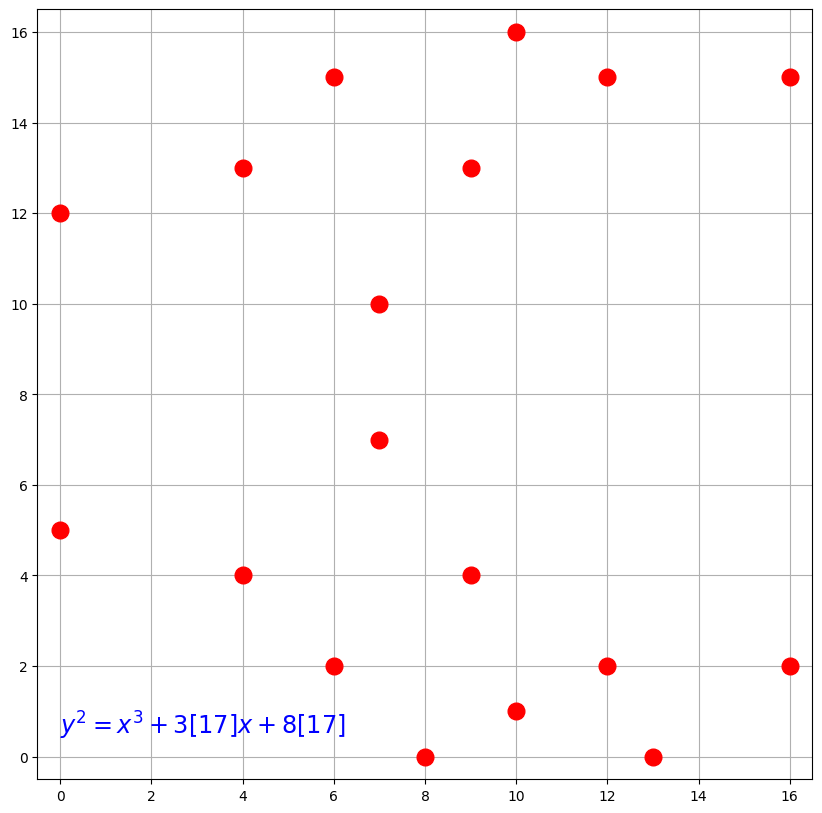

[(None, None), (0, 5), (0, 12), (4, 4), (4, 13), (6, 2), (6, 15), (7, 7), (7, 10), (8, 0), (9, 4), (9, 13), (10, 1), (10, 16), (12, 2), (12, 15), (13, 0), (16, 2), (16, 15)]


In [11]:
a = 3
b = 8
E = EllipticCurve(a, b)
print(E)
E.drawPoints()
print(list(map(lambda el: (el.x, el.y), E.points)))